In [124]:
import pandas as pd
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import yaml
import pypsa
import calendar

from matplotlib.cm import ScalarMappable
from pypsa.descriptors import Dict
from scipy import stats
import seaborn as sns

from math import radians, cos, sin, asin, sqrt

from matplotlib.colors import Normalize as mcNormalize
from matplotlib.cm import ScalarMappable

In [125]:
def load_configuration(config_path):
    """
    Load configuration settings from a YAML file.
    """
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    return config


snakemake = Dict()
snakemake.config = load_configuration("../config.yaml")
snakemake.input = Dict()
snakemake.output = Dict()

run = "paper-DKDEPT-1H-allflex-noexcess-nocostshifts"  # run name from config.yaml
distance = snakemake["config"]["scenario"]["distance"][0]  # pair name from config.yaml

if True:
    folder = f"/results/{run}"
    scenario = f"/2025/p1/cfe100/{distance}"

    snakemake.input.data = f"{folder}/networks/{scenario}/{distance}/40.nc"
    snakemake.output.plot = f"../manuscript/images/plot.pdf"

    n = pypsa.Network(f"../{folder}/networks/{scenario}/40.nc")

INFO:pypsa.io:Imported network 40.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [126]:
datacenters = snakemake.config["ci"][f"{distance}"]["datacenters"]
locations = list(datacenters.keys())
names = list(datacenters.values())
names

['Denmark', 'Germany', 'Portugal']

In [127]:
rename = {
    f"{name} {suffix}": category
    for name in names
    for suffix, category in {
        "H2 Electrolysis": "hydrogen storage",
        "H2 Fuel Cell": "hydrogen storage",
        "battery charger": "battery storage",
        "battery discharger": "battery storage",
        "export": "grid",
        "import": "grid",
        "onwind": "wind",
        "solar": "solar",
        "load": "load",
        "adv_geothermal": "clean dispatchable",
        "allam_ccs": "NG-Allam",
        "DSM-delayout": "temporal shift",
        "DSM-delayin": "temporal shift",
    }.items()
}

In [128]:
def retrieve_nb(n, node):
    """
    Retrieve nodal energy balance per hour
        -> lines and links are bidirectional AND their subsets are exclusive.
        -> links include fossil gens
    NB {-1} multiplier is a nodal balance sign
    """

    components = ["Generator", "Load", "StorageUnit", "Store", "Link", "Line"]
    nodal_balance = pd.DataFrame(index=n.snapshots)

    for i in components:
        if i == "Generator":
            node_generators = n.generators.query("bus==@node").index
            nodal_balance = nodal_balance.join(n.generators_t.p[node_generators])
        if i == "Load":
            node_loads = n.loads.query("bus==@node").index
            nodal_balance = nodal_balance.join(-1 * n.loads_t.p_set[node_loads])
        if i == "Link":
            node_export_links = n.links.query("bus0==@node").index
            node_import_links = n.links.query("bus1==@node").index
            nodal_balance = nodal_balance.join(-1 * n.links_t.p0[node_export_links])
            nodal_balance = nodal_balance.join(-1 * n.links_t.p1[node_import_links])
            ##################
        if i == "StorageUnit":
            # node_storage_units = n.storage_units.query('bus==@node').index
            # nodal_balance = nodal_balance.join(n.storage_units_t.p_dispatch[node_storage_units])
            # nodal_balance = nodal_balance.join(n.storage_units_t.p_store[node_storage_units])
            continue
        if i == "Line":
            continue
        if i == "Store":
            continue

    nodal_balance = nodal_balance.rename(columns=rename).groupby(level=0, axis=1).sum()

    # Custom groupby function
    def custom_groupby(column_name):
        if column_name.startswith("vcc"):
            return "spatial shift"
        return column_name

    # Apply custom groupby function
    nodal_balance = nodal_balance.groupby(custom_groupby, axis=1).sum()

    # revert nodal balance sign for display
    if "spatial shift" in nodal_balance.columns:
        nodal_balance["spatial shift"] = nodal_balance["spatial shift"] * -1
    if "temporal shift" in nodal_balance.columns:
        nodal_balance["temporal shift"] = nodal_balance["temporal shift"] * -1

    return nodal_balance

In [129]:
data = retrieve_nb(n, node=names[0]).get("temporal shift")
data

snapshot
2013-01-01 00:00:00    6.167047
2013-01-01 01:00:00    6.452254
2013-01-01 02:00:00    6.656701
2013-01-01 03:00:00    6.854534
2013-01-01 04:00:00    7.091868
                         ...   
2013-12-31 19:00:00    6.796168
2013-12-31 20:00:00    6.720655
2013-12-31 21:00:00    6.668506
2013-12-31 22:00:00    6.285141
2013-12-31 23:00:00    6.554350
Name: temporal shift, Length: 8760, dtype: float64

In [130]:
def prepare_heatmap_data(df, month, location, carrier, scaling, diff_location=None):
    data = df[df["snapshot"].dt.month == month]
    day = data["snapshot"].dt.day
    value = data[f"{location} {carrier}"].values

    if diff_location:
        diff_value = data[f"{diff_location} {carrier}"].values
        value -= diff_value  # Subtracting the second time-series from the first

    value = value.reshape(int(24 / scaling), len(day.unique()), order="F")
    return day, value


def draw_heatmap(ax, day, value, scaling, colormap, min_val, max_val):
    xgrid = np.arange(day.max() + 1) + 1  # for days
    ygrid = np.arange(int(24 / scaling) + 1)  # for hours

    # Ensure the dimensions of 'value' match the expected dimensions for 'xgrid' and 'ygrid'
    if value.shape != (len(ygrid) - 1, len(xgrid) - 1):
        raise ValueError(
            f"Shape of value ({value.shape}) does not match xgrid ({len(xgrid)}) and ygrid ({len(ygrid)}) dimensions."
        )

    ax.pcolormesh(xgrid, ygrid, value, cmap=colormap, vmin=min_val, vmax=max_val)
    ax.set_ylim(int(24 / scaling), 0)
    ax.axis("off")


def plot_heatmap_cf(
    df,
    location,
    carrier,
    scaling,
    colormap,
    min_val,
    max_val,
    year=2013,
    figsize=(14, 5),
    plot_difference=False,
    diff_location=None,
):
    fig, axes = plt.subplots(1, 12, figsize=figsize, sharey=True)
    plt.tight_layout()

    for month, ax in enumerate(axes, start=1):
        # Pass additional parameters if plotting the difference
        day, value = prepare_heatmap_data(
            df,
            month,
            location,
            carrier,
            scaling,
            diff_location=diff_location if plot_difference else None,
        )
        draw_heatmap(ax, day, value, scaling, colormap, min_val, max_val)
        ax.set_title(calendar.month_abbr[month], fontsize=10, pad=3)

    fig.subplots_adjust(
        left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0.1, bottom=0.15
    )
    cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.04])
    norm = mc.Normalize(min_val, max_val)
    cb = fig.colorbar(
        ScalarMappable(norm=norm, cmap=colormap), cax=cbar_ax, orientation="horizontal"
    )
    cb.set_label("Hourly Capacity Factor (%)", size=14)

    fig.text(0.12, 0.12, "Day of the Month", ha="center", va="center", fontsize=14)
    fig.text(
        0.04,
        0.34,
        "Hour of the Day",
        ha="center",
        va="center",
        rotation="vertical",
        fontsize=14,
    )

    annotations = [
        (
            f"Location: {location}"
            if not plot_difference
            else f"Location: {location} vs {diff_location}"
        ),
        f"Carrier: {carrier}",
        f"Weather Year: {year}",
        r"Unit: MWh·h$^{-1}$",
    ]
    for i, annotation in enumerate(annotations):
        fig.text(
            0.95,
            0.12 - i * 0.05,
            annotation,
            ha="right",
            va="center",
            fontsize=14,
            color="black",
        )

    fig.savefig("test.pdf", bbox_inches="tight", transparent=True)

In [131]:
df = (
    n.generators_t.p_max_pu.filter(regex=f"{names[0]}")
    .reset_index()
    .rename(columns={"index": "snapshot"})
    .assign(snapshot=lambda x: pd.to_datetime(x["snapshot"]))
)
df

Generator,snapshot,Denmark onwind,Denmark solar
0,2013-01-01 00:00:00,0.874591,0.0
1,2013-01-01 01:00:00,0.764173,0.0
2,2013-01-01 02:00:00,0.600202,0.0
3,2013-01-01 03:00:00,0.489448,0.0
4,2013-01-01 04:00:00,0.416427,0.0
...,...,...,...
8755,2013-12-31 19:00:00,0.748420,0.0
8756,2013-12-31 20:00:00,0.759332,0.0
8757,2013-12-31 21:00:00,0.763581,0.0
8758,2013-12-31 22:00:00,0.786359,0.0


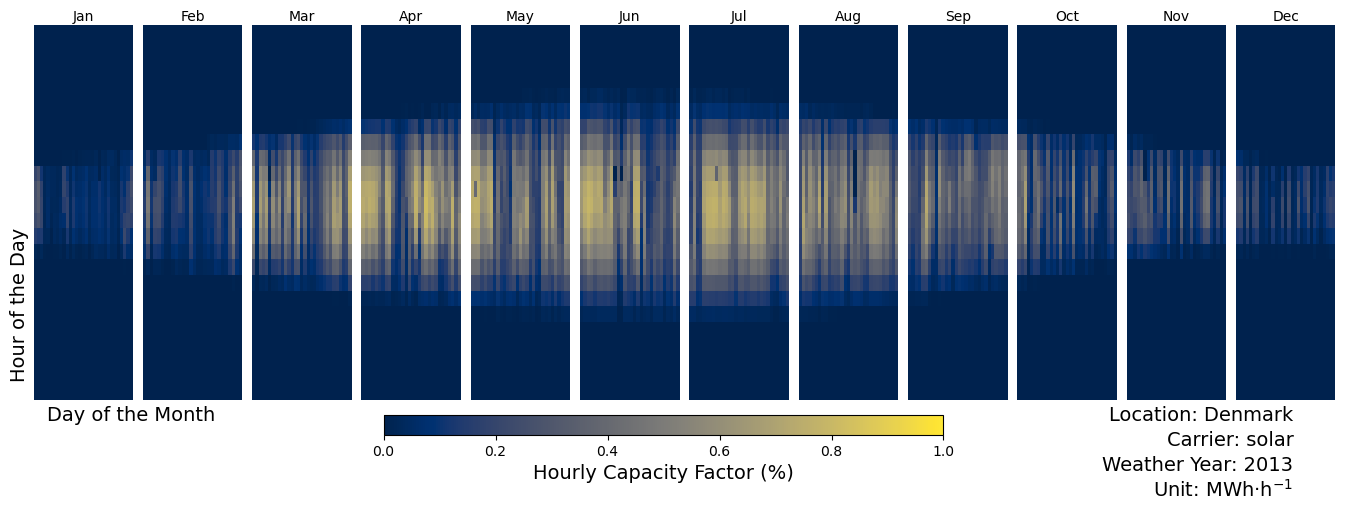

In [132]:
location = "Denmark"
carrier = "solar"
scaling = int(snakemake.config["time_sampling"][0])  # temporal scaling -- 3/1 for 3H/1H
colormap = "cividis"  # "cividis" # "RdBu"  # https://matplotlib.org/stable/tutorials/colors/colormaps.html
MIN, MAX = 0, 1  #  df["denmark onwind"].min()

plot_heatmap_cf(
    df,
    location,
    carrier,
    scaling,
    colormap,
    MIN,
    MAX,
    diff_location=f" ",
    plot_difference=False,
)

In [133]:
df = retrieve_nb(n, node=names[0]).get("temporal shift")
data = df[df.index.month == month]
day = data.index.day

In [134]:
def prepare_heatmap_shifts(shift_type, month, location, scaling):
    df = retrieve_nb(n, node=f"{location}").get(f"{shift_type}")
    data = df[df.index.month == month]
    day = data.index.day
    value = data.values

    value = value.reshape(int(24 / scaling), len(day.unique()), order="F")
    return day, value


def draw_heatmap(ax, day, value, scaling, colormap, min_val, max_val):
    xgrid = np.arange(day.max() + 1) + 1  # for days
    ygrid = np.arange(int(24 / scaling) + 1)  # for hours

    # Ensure the dimensions of 'value' match the expected dimensions for 'xgrid' and 'ygrid'
    if value.shape != (len(ygrid) - 1, len(xgrid) - 1):
        raise ValueError(
            f"Shape of value ({value.shape}) does not match xgrid ({len(xgrid)}) and ygrid ({len(ygrid)}) dimensions."
        )

    ax.pcolormesh(xgrid, ygrid, value, cmap=colormap, vmin=min_val, vmax=max_val)
    ax.set_ylim(int(24 / scaling), 0)
    ax.axis("off")


def plot_heatmap_shifts(
    shift_type,
    location,
    scaling,
    colormap,
    min_val,
    max_val,
    year=2013,
    figsize=(14, 5),
    plot_difference=False,
):
    fig, axes = plt.subplots(1, 12, figsize=figsize, sharey=True)
    plt.tight_layout()

    for month, ax in enumerate(axes, start=1):
        # Pass additional parameters if plotting the difference
        day, value = prepare_heatmap_shifts(shift_type, month, location, scaling)
        draw_heatmap(ax, day, value, scaling, colormap, min_val, max_val)
        ax.set_title(calendar.month_abbr[month], fontsize=10, pad=3)

    fig.subplots_adjust(
        left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0.0, bottom=0.15
    )
    cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.04])
    norm = mc.Normalize(min_val, max_val)
    cb = fig.colorbar(
        ScalarMappable(norm=norm, cmap=colormap), cax=cbar_ax, orientation="horizontal"
    )

    fig.text(0.12, 0.12, "Day of the Month", ha="center", va="center", fontsize=14)
    fig.text(
        0.04,
        0.34,
        "Hour of the Day",
        ha="center",
        va="center",
        rotation="vertical",
        fontsize=14,
    )

    annotations = [
        f"Location: {location}",
        f"Type: {shift_type}",
        r"Unit: MWh·h$^{-1}$",
    ]
    for i, annotation in enumerate(annotations):
        fig.text(
            0.95,
            0.12 - i * 0.05,
            annotation,
            ha="right",
            va="center",
            fontsize=14,
            color="black",
        )

    fig.savefig("test.pdf", bbox_inches="tight", transparent=True)

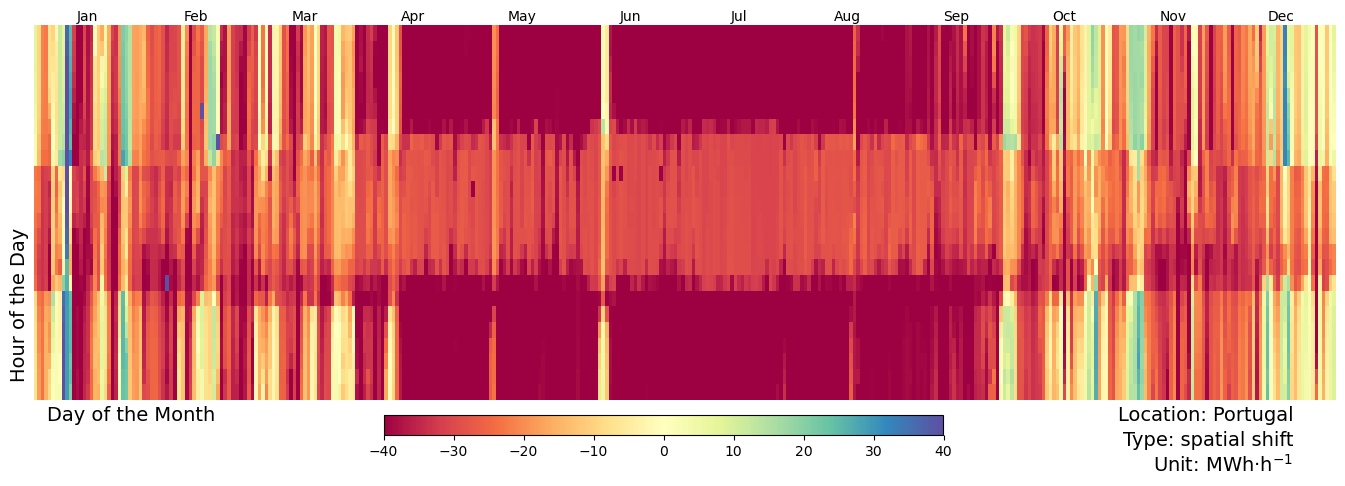

In [142]:
plot_heatmap_shifts(
    shift_type="spatial shift",
    location="Portugal",
    scaling=1,
    colormap="Spectral",
    min_val=-40.0,  # - int(flex)
    max_val=+40.0,  # + int(flex)
    figsize=(14, 5),
)